In [ ]:

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from random import sample

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [ ]:
train_path='/content/drive/MyDrive/BVD/Train'
val_path='/content/drive/MyDrive/BVD/Val'
test_path='/content/drive/MyDrive/BVD/Test'

In [ ]:
df_train=pd.DataFrame(columns=['path','label'])
df_val=pd.DataFrame(columns=['path','label'])
df_test=pd.DataFrame(columns=['path','label'])

In [ ]:
os.listdir(train_path)

['Bird', 'Drone']

In [ ]:
IMAGE_SAMPLES=None      # Pass image samples as None to take all samples of images

# CHOOSE 1 OF THE CATEGORIES

# categories=['Bread','Dessert','Meat','Soup']    # only 4 categories
categories=os.listdir(train_path)          # list of all categories

def limit_data(data_dir,categories,n=None):
    '''
    This function limits the number of samples in each class and return the dataframe
    '''
    a=[]
    for i in categories:
        for k,j in enumerate(os.listdir(data_dir+'/'+i)):
            if n!=None and k>=n:break;
            a.append((f'{data_dir}/{i}/{j}',i))
    return pd.DataFrame(a,columns=['path','label'])


df_train=limit_data(train_path,categories,IMAGE_SAMPLES)
df_val=limit_data(val_path,categories,IMAGE_SAMPLES)
df_test=limit_data(test_path,categories,IMAGE_SAMPLES)

In [ ]:
df_train['label'].value_counts()

Drone    308
Bird     300
Name: label, dtype: int64

In [ ]:
df_val['label'].value_counts()

Drone    60
Bird     50
Name: label, dtype: int64

In [ ]:
df_test['label'].value_counts()

Drone    60
Bird     50
Name: label, dtype: int64

In [ ]:
df_train=df_train.sample(frac=1)
df_val=df_val.sample(frac=1)
df_test=df_test.sample(frac=1)

In [ ]:
df_train

,path,label
65,/content/drive/MyDrive/BVD/Train/Bird/singleBi...,Bird
237,/content/drive/MyDrive/BVD/Train/Bird/singleBi...,Bird
147,/content/drive/MyDrive/BVD/Train/Bird/singleBi...,Bird
465,/content/drive/MyDrive/BVD/Train/Drone/238.JPEG,Drone
187,/content/drive/MyDrive/BVD/Train/Bird/singleBi...,Bird
...,...,...
129,/content/drive/MyDrive/BVD/Train/Bird/singleBi...,Bird
144,/content/drive/MyDrive/BVD/Train/Bird/singleBi...,Bird
72,/content/drive/MyDrive/BVD/Train/Bird/singleBi...,Bird
235,/content/drive/MyDrive/BVD/Train/Bird/singleBi...,Bird


In [ ]:
df_val

,path,label
57,/content/drive/MyDrive/BVD/Val/Drone/singleDro...,Drone
66,/content/drive/MyDrive/BVD/Val/Drone/singleDro...,Drone
49,/content/drive/MyDrive/BVD/Val/Bird/singleBird...,Bird
36,/content/drive/MyDrive/BVD/Val/Bird/singleBird...,Bird
98,/content/drive/MyDrive/BVD/Val/Drone/singleDro...,Drone
...,...,...
21,/content/drive/MyDrive/BVD/Val/Bird/singleBird...,Bird
94,/content/drive/MyDrive/BVD/Val/Drone/singleDro...,Drone
34,/content/drive/MyDrive/BVD/Val/Bird/singleBird...,Bird
22,/content/drive/MyDrive/BVD/Val/Bird/singleBird...,Bird


In [ ]:
df_test

,path,label
8,/content/drive/MyDrive/BVD/Test/Bird/singleBir...,Bird
11,/content/drive/MyDrive/BVD/Test/Bird/singleBir...,Bird
9,/content/drive/MyDrive/BVD/Test/Bird/singleBir...,Bird
29,/content/drive/MyDrive/BVD/Test/Bird/singleBir...,Bird
17,/content/drive/MyDrive/BVD/Test/Bird/singleBir...,Bird
...,...,...
103,/content/drive/MyDrive/BVD/Test/Drone/yoto0646...,Drone
43,/content/drive/MyDrive/BVD/Test/Bird/singleBir...,Bird
37,/content/drive/MyDrive/BVD/Test/Bird/singleBir...,Bird
38,/content/drive/MyDrive/BVD/Test/Bird/singleBir...,Bird


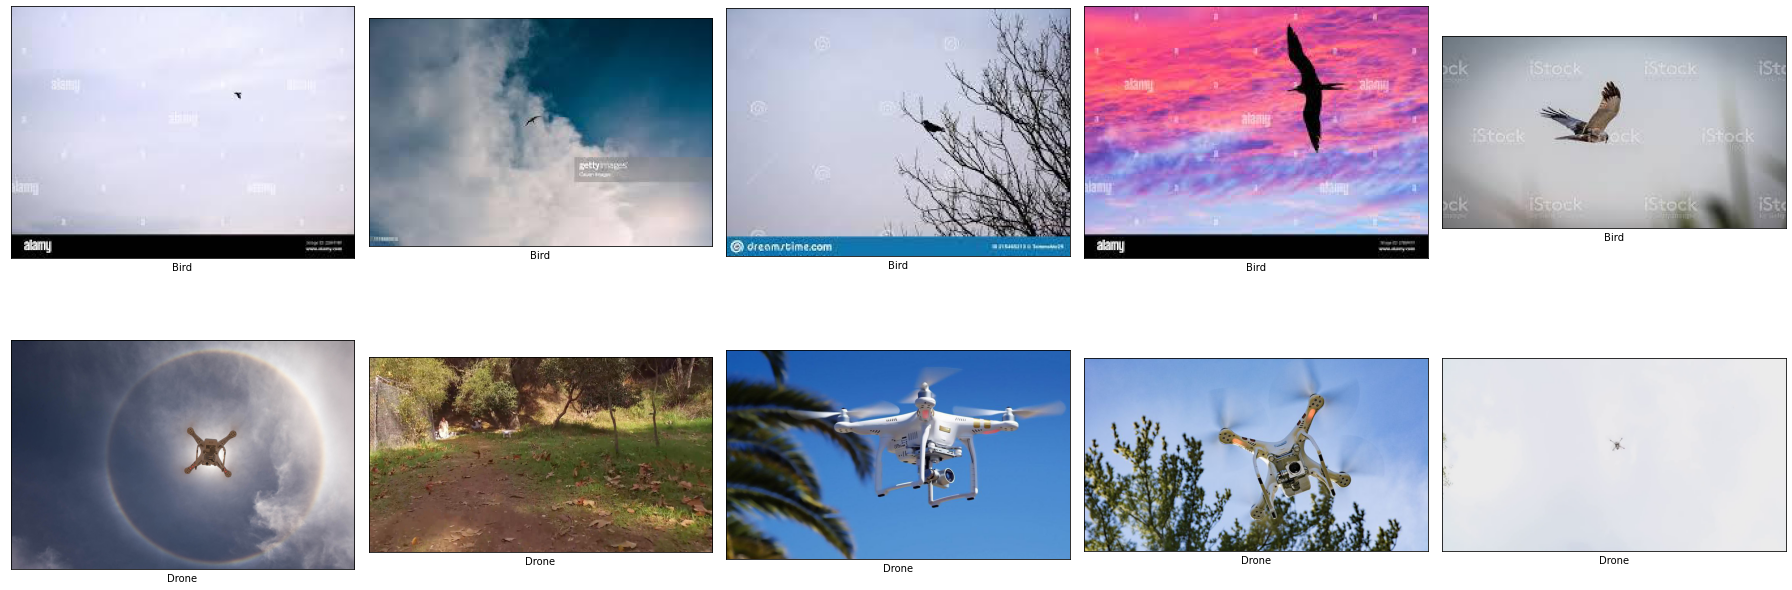

In [ ]:
# Randomly display 5 images under each of the 2 categories from the training data.
# You will see different images each time.
fig, axs = plt.subplots(len(df_train['label'].unique()), 5, figsize = (25, 10))
for i,cat in enumerate(categories):
    path_cat=df_train[df_train['label']==cat].path.values[:5]        # take only 5 categories
    for j, path in enumerate(path_cat):
#         images = sample(df_train[item], 5)

        img = PIL.Image.open(path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = cat, xticks = [], yticks = [])

fig.tight_layout()

In [ ]:
# Image generator with Augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    zoom_range = 0.2,
    horizontal_flip = True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8,1.0]
)

val_datagen=ImageDataGenerator(rescale=1./255)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#without augmentation
train_data=train_datagen.flow_from_dataframe(df_train,x_col='path',y_col='label',target_size=(256, 256),batch_size=32,
                                             class_mode='binary',seed=42)


val_data=val_datagen.flow_from_dataframe(df_val,x_col='path',y_col='label',target_size=(256, 256),batch_size=32,
                                           class_mode='binary',seed=42,shuffle = False)


# augmentation
train_data_aug=train_datagen_aug.flow_from_dataframe(df_train,x_col='path',y_col='label',target_size=(256, 256),
                                                     batch_size=32,class_mode='binary',seed=42)


#test data
test_data=test_datagen.flow_from_dataframe(df_test,x_col='path',y_col='label',target_size=(256, 256),batch_size=32,
                                           class_mode='binary',seed=42,shuffle = False)

Found 606 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.
Found 606 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:989: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [ ]:
# Which class belongs to which label
train_data.class_indices

{'Bird': 0, 'Drone': 1}

# Show Augmented images

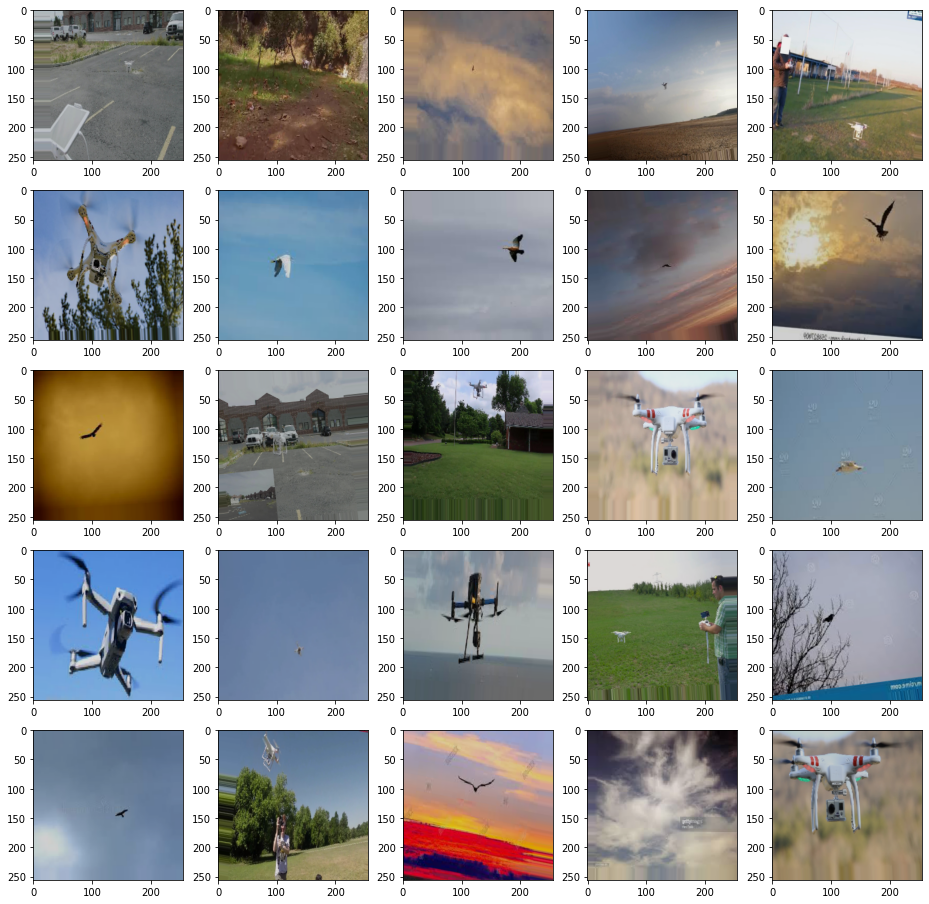

In [ ]:
w = 10
h = 10

x= train_data_aug.next()
image = x[0]      # img=x[0], label=x[1]
fig = plt.figure(figsize=(16, 16))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = image[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
import itertools,matplotlib
from itertools import product

min_val, max_val = 0.3,1.0
n = 10
orig_cmap = plt.cm.Blues
colors = orig_cmap(np.linspace(min_val, max_val, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)


def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=cmap):

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Training the model

In [ ]:
input_layer=Input(shape=(256,256,3))

layer=Conv2D(filters=128,kernel_size=(3,3),activation="relu")(input_layer)
layer=MaxPool2D(pool_size=(2,2),strides=(1,1))(layer)
layer=BatchNormalization()(layer)
# layer=Dropout(0.6)(layer)

layer=Conv2D(filters=64,kernel_size=(3,3),activation="relu")(layer)
layer=MaxPool2D(pool_size=(2,2),strides=(1,1))(layer)
layer=BatchNormalization()(layer)
# layer=Dropout(0.6)(layer)

layer=Conv2D(filters=32,kernel_size=(3,3),activation="relu")(layer)
layer=MaxPool2D(pool_size=(2,2),strides=(1,1))(layer)
layer=BatchNormalization()(layer)
# layer=Dropout(0.6)(layer)

layer=Conv2D(filters=16,kernel_size=(3,3),activation="relu")(layer)
layer=MaxPool2D(pool_size=(2,2),strides=(1,1))(layer)
layer=BatchNormalization()(layer)
# layer=Dropout(0.6)(layer)

layer=Flatten()(layer)
layer=Dense(256,activation="relu")(layer)
layer=Dense(128,activation="relu")(layer)
layer=Dense(64,activation="relu")(layer)
layer=Dense(32,activation="relu")(layer)
output_layer=Dense(1,activation="sigmoid")(layer)

In [ ]:
model=Model(inputs=input_layer,outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 253, 253, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 253, 253, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 251, 251, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 250, 250, 64)     0     

In [ ]:
model_aug=Model(inputs=input_layer,outputs=output_layer)
model_aug.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 253, 253, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 253, 253, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 251, 251, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 250, 250, 64)     0   

In [ ]:
model.compile(loss='binary_crossentropy',
       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
       metrics=['accuracy','AUC'])

model_aug.compile(loss='binary_crossentropy',
       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
       metrics=['accuracy','AUC'])

# Without augmentation

In [ ]:
history = model.fit(
    train_data,
    epochs=25,
    validation_data=val_data
#     callbacks=[lr_schedule]
)

Epoch 1/25
19/19 [==============================] - 18s 895ms/step - loss: 3.9275 - accuracy: 0.7954 - auc: 0.8239 - val_loss: 26.8788 - val_accuracy: 0.4909 - val_auc: 0.5270
Epoch 2/25
19/19 [==============================] - 18s 904ms/step - loss: 3.5234 - accuracy: 0.8482 - auc: 0.8732 - val_loss: 9.4135 - val_accuracy: 0.5636 - val_auc: 0.6050
Epoch 3/25
19/19 [==============================] - 17s 884ms/step - loss: 2.9609 - accuracy: 0.8597 - auc: 0.8941 - val_loss: 20.3599 - val_accuracy: 0.5818 - val_auc: 0.6078
Epoch 4/25
19/19 [==============================] - 17s 878ms/step - loss: 1.7251 - accuracy: 0.8960 - auc: 0.9116 - val_loss: 10.0510 - val_accuracy: 0.5636 - val_auc: 0.6118
Epoch 5/25
19/19 [==============================] - 17s 884ms/step - loss: 1.8800 - accuracy: 0.8746 - auc: 0.9122 - val_loss: 10.4062 - val_accuracy: 0.6091 - val_auc: 0.6393
Epoch 6/25
19/19 [==============================] - 17s 893ms/step - loss: 2.3233 - accuracy: 0.8696 - auc: 0.9014 - val_

# Training curve

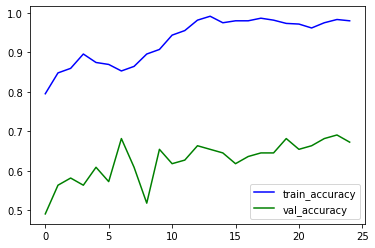

In [ ]:
hist=history.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.legend(loc="lower right")
plt.show()

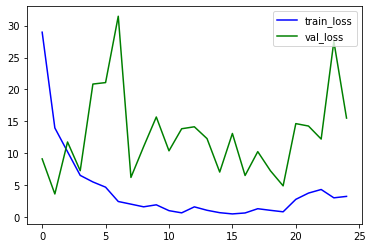

In [ ]:
#Loss curve
hist=history.history
plt.plot(hist["loss"],color="b",label="train_loss")
plt.plot(hist["val_loss"],color="g",label="val_loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
model.evaluate(train_data)

19/19 [==============================] - 87s 4s/step - loss: 0.6934 - accuracy: 0.5033 - auc: 0.4537


[0.6933658123016357, 0.5033003091812134, 0.4536956250667572]

In [ ]:
model.evaluate(val_data)

4/4 [==============================] - 23s 7s/step - loss: 0.6930 - accuracy: 0.4909 - auc: 0.5583


[0.6929500102996826, 0.4909090995788574, 0.5583333373069763]

In [ ]:
model.evaluate(test_data)

4/4 [==============================] - 19s 6s/step - loss: 0.6933 - accuracy: 0.4818 - auc: 0.5017


[0.6932811141014099, 0.48181816935539246, 0.5016666650772095]

In [ ]:
y_test_pred=model.predict(test_data)

4/4 [==============================] - 1s 275ms/step


In [ ]:
y_true=pd.Series(test_data.classes)
y_true

0      0
1      0
2      0
3      0
4      0
      ..
105    1
106    0
107    0
108    0
109    0
Length: 110, dtype: int64

In [ ]:
print(len(y_test_pred))
# print(y_test_pred[:20])

110


In [ ]:
auc=metrics.roc_auc_score(y_true,y_test_pred)
auc

0.8551666666666666

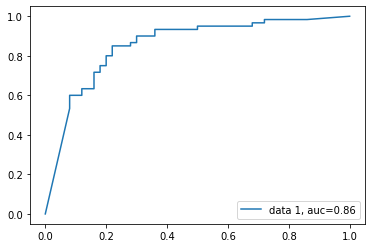

In [ ]:
# calculate roc curve
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_test_pred)

#plot the roc curve
plt.plot(fpr,tpr,label="data 1, auc="+str(round(auc,2)))
plt.legend(loc=4)
plt.show()

# find optimal threshold
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]
# print("Threshold value is:", optimal_threshold)

In [ ]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
gmeans

array([0.        , 0.70047603, 0.74296702, 0.72663608, 0.74654761,
       0.7293833 , 0.77588659, 0.7665942 , 0.78421936, 0.77459667,
       0.8       , 0.78993671, 0.81424812, 0.78230429, 0.78993671,
       0.7788881 , 0.79372539, 0.78230429, 0.75894664, 0.77287343,
       0.68313005, 0.68920244, 0.55136195, 0.55617743, 0.52025635,
       0.52472215, 0.37103459, 0.        ])

In [ ]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold=thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (optimal_threshold, gmeans[ix]))

Best Threshold=0.073802, G-Mean=0.814


In [ ]:
y_test_pred_index=[]
for i,pred in enumerate(y_test_pred):
    if pred>=optimal_threshold:
        y_test_pred_index.append(1)
    else:
        y_test_pred_index.append(0)


# print(y_test_pred_index)

In [ ]:
pd.Series(y_test_pred_index).value_counts()

1    62
0    48
dtype: int64

# Confusion matrix for No augmentation

In [ ]:
cm=confusion_matrix(y_true,y_test_pred_index)

Confusion matrix, without normalization


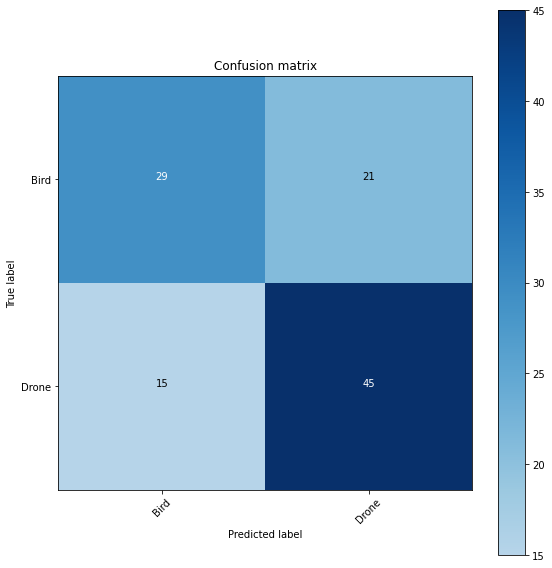

In [ ]:
plot_confusion_matrix(cm,classes=categories)

In [ ]:
cnt=0
for i in range(len(y_true)):
    if y_true[i]==y_test_pred_index[i]:
        cnt+=1

print('acc:', cnt/len(y_true)*100)


acc: 67.27272727272727


In [ ]:
print(len(y_true))

110


In [ ]:
print(list(y_true))
print(y_test_pred_index)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0]


In [ ]:
metrics.accuracy_score(y_true,y_test_pred_index)

0.6727272727272727

### ClassWise accuracy without Augmentation

In [ ]:
class_wise_acc=cm.diagonal()/cm.sum(axis=0)


In [ ]:
for i,cat in enumerate(categories):
    print(f'Class wise {cat} accuracy :{np.round(class_wise_acc[i]*100,2)}')

Class wise Bird accuracy :65.91
Class wise Drone accuracy :68.18


# Augmentation model

In [ ]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1,
    patience = 4
)

In [ ]:
history_aug=model_aug.fit(
    train_data_aug,
    epochs=25,
    validation_data=val_data
#     callbacks=[earlystopping]
)

Epoch 1/25
19/19 [==============================] - 38s 2s/step - loss: 27.6302 - accuracy: 0.6601 - auc: 0.6717 - val_loss: 5.0368 - val_accuracy: 0.4818 - val_auc: 0.5247
Epoch 2/25
19/19 [==============================] - 22s 1s/step - loss: 25.7710 - accuracy: 0.6601 - auc: 0.6614 - val_loss: 3.8957 - val_accuracy: 0.5091 - val_auc: 0.5412
Epoch 3/25
19/19 [==============================] - 21s 1s/step - loss: 20.4746 - accuracy: 0.6799 - auc: 0.6903 - val_loss: 13.2738 - val_accuracy: 0.4545 - val_auc: 0.4660
Epoch 4/25
19/19 [==============================] - 21s 1s/step - loss: 10.9079 - accuracy: 0.7211 - auc: 0.7336 - val_loss: 12.5135 - val_accuracy: 0.4455 - val_auc: 0.4857
Epoch 5/25
19/19 [==============================] - 21s 1s/step - loss: 10.3488 - accuracy: 0.7525 - auc: 0.7692 - val_loss: 29.0194 - val_accuracy: 0.4545 - val_auc: 0.5000
Epoch 6/25
19/19 [==============================] - 22s 1s/step - loss: 5.9560 - accuracy: 0.7789 - auc: 0.7898 - val_loss: 3.7667 -

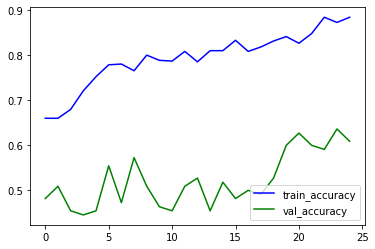

In [ ]:
hist=history_aug.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.legend(loc="lower right")
plt.show()

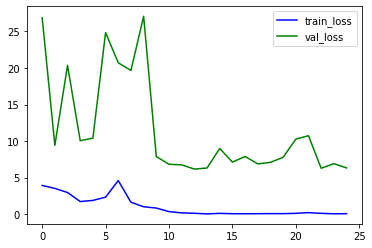

In [ ]:
#Loss curve
hist=history.history
plt.plot(hist["loss"],color="b",label="train_loss")
plt.plot(hist["val_loss"],color="g",label="val_loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
model_aug.evaluate(train_data_aug)

19/19 [==============================] - 18s 930ms/step - loss: 0.3365 - accuracy: 0.8960 - auc: 0.9506


[0.336492657661438, 0.896039605140686, 0.9505688548088074]

In [ ]:
model_aug.evaluate(val_data)

4/4 [==============================] - 1s 125ms/step - loss: 1.7334 - accuracy: 0.7182 - auc: 0.7750


[1.7334444522857666, 0.7181817889213562, 0.7749999761581421]

In [ ]:
model_aug.evaluate(test_data)

4/4 [==============================] - 1s 240ms/step - loss: 2.2188 - accuracy: 0.7818 - auc: 0.8273


[2.2188379764556885, 0.7818182110786438, 0.8273332715034485]

In [ ]:
y_test_pred_aug=model_aug.predict(test_data)

4/4 [==============================] - 1s 266ms/step


In [ ]:
y_true=pd.Series(test_data.classes)
y_true

0      0
1      0
2      0
3      0
4      0
      ..
105    1
106    0
107    0
108    0
109    0
Length: 110, dtype: int64

In [ ]:
auc_aug=metrics.roc_auc_score(y_true,y_test_pred_aug)
auc_aug

0.5113333333333333

In [ ]:
print(len(y_test_pred_aug))
print(y_test_pred_aug[0])

110
[0.49950677]


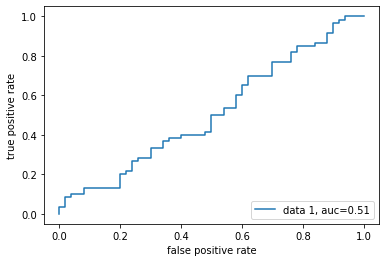

Threshold value is: 0.49948537


In [ ]:
# calculate roc curve
fpr_a, tpr_a, thresholds = metrics.roc_curve(y_true, y_test_pred_aug)

#plot roc curve
plt.plot(fpr_a,tpr_a,label="data 1, auc="+str(round(auc_aug,2)))
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.legend(loc=4)
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

In [ ]:
print(thresholds)

[2.00000000e+00 1.00000000e+00 9.99999881e-01 9.83099163e-01
 9.73189116e-01 5.56992233e-01 5.23316383e-01 4.77914631e-01
 4.22399074e-01 4.05771792e-01 3.86035055e-01 3.62162292e-01
 3.06527078e-01 2.76217580e-01 2.73068696e-01 2.59032875e-01
 1.90331340e-01 1.82078421e-01 1.61391646e-01 1.52396858e-01
 1.07680887e-01 6.63353950e-02 4.62250225e-02 4.10082228e-02
 1.09908276e-03 2.40411260e-04 4.82112046e-05 2.36294691e-05
 1.73795434e-05 3.06644597e-06 8.58227907e-07 1.46980113e-07
 1.19773125e-08 1.01132631e-08 1.22743454e-10 3.58031833e-11
 5.41068926e-13 8.13875927e-15 5.79053428e-17 2.08567206e-17
 1.65097556e-21 8.97650605e-22 3.43791893e-24]


[https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

In [ ]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr_a * (1-fpr_a))
gmeans

array([0.        , 0.12909944, 0.18257419, 0.18073922, 0.2857738 ,
       0.28284271, 0.30983867, 0.30331502, 0.35023801, 0.32659863,
       0.4       , 0.39496835, 0.4110961 , 0.40579141, 0.45018515,
       0.44422217, 0.45789373, 0.44534631, 0.48304589, 0.46904158,
       0.49193496, 0.48442406, 0.49531135, 0.47958315, 0.48989795,
       0.45607017, 0.46547467, 0.45643546, 0.5       , 0.47958315,
       0.49531135, 0.47328638, 0.50199602, 0.48989795, 0.50990195,
       0.49699095, 0.51575188, 0.45825757, 0.47958315, 0.42895221,
       0.44271887, 0.42387105, 0.43243497, 0.41231056, 0.36878178,
       0.37237973, 0.32249031, 0.33166248, 0.30276504, 0.31091264,
       0.27808871, 0.28047579, 0.24289916, 0.24494897, 0.14142136,
       0.        ])

In [ ]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold=thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (optimal_threshold, gmeans[ix]))

Best Threshold=0.405772, G-Mean=0.793


In [ ]:
y_test_pred_aug_index=[]
for i,pred in enumerate(y_test_pred_aug):
    if pred>=optimal_threshold:
        y_test_pred_aug_index.append(1)
    else:
        y_test_pred_aug_index.append(0)
# print(y_test_pred_aug_index)

In [ ]:
pd.Series(y_test_pred_aug_index).value_counts()

0    65
1    45
dtype: int64

In [ ]:
metrics.accuracy_score(y_true,y_test_pred_aug_index)

0.7909090909090909

In [ ]:
cm_aug=confusion_matrix(y_true,y_test_pred_aug_index)

# Confusion matrix for augmentation

Confusion matrix, without normalization


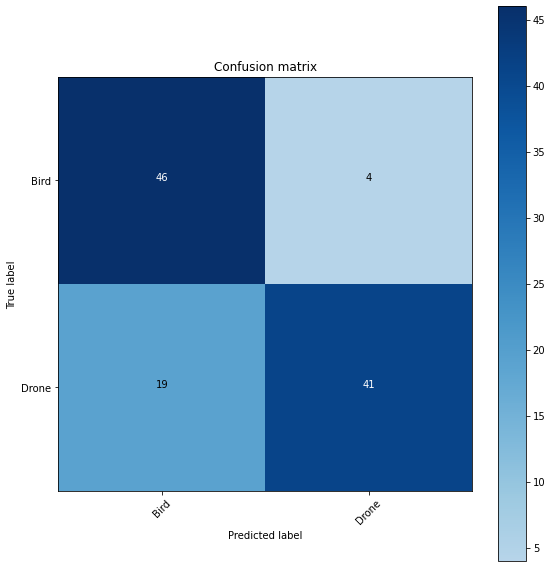

In [ ]:
plot_confusion_matrix(cm_aug,classes=categories)

### ClassWise accuracy with Augmentation

In [ ]:
class_wise_aug_acc=cm_aug.diagonal()/cm_aug.sum(axis=0)

In [ ]:
class_wise_aug_acc

array([0.70769231, 0.91111111])

In [ ]:
for i,cat in enumerate(categories):
    print(f'Class wise {cat} accuracy :{np.round(class_wise_aug_acc[i]*100,2)}')

Class wise Bird accuracy :70.77
Class wise Drone accuracy :91.11


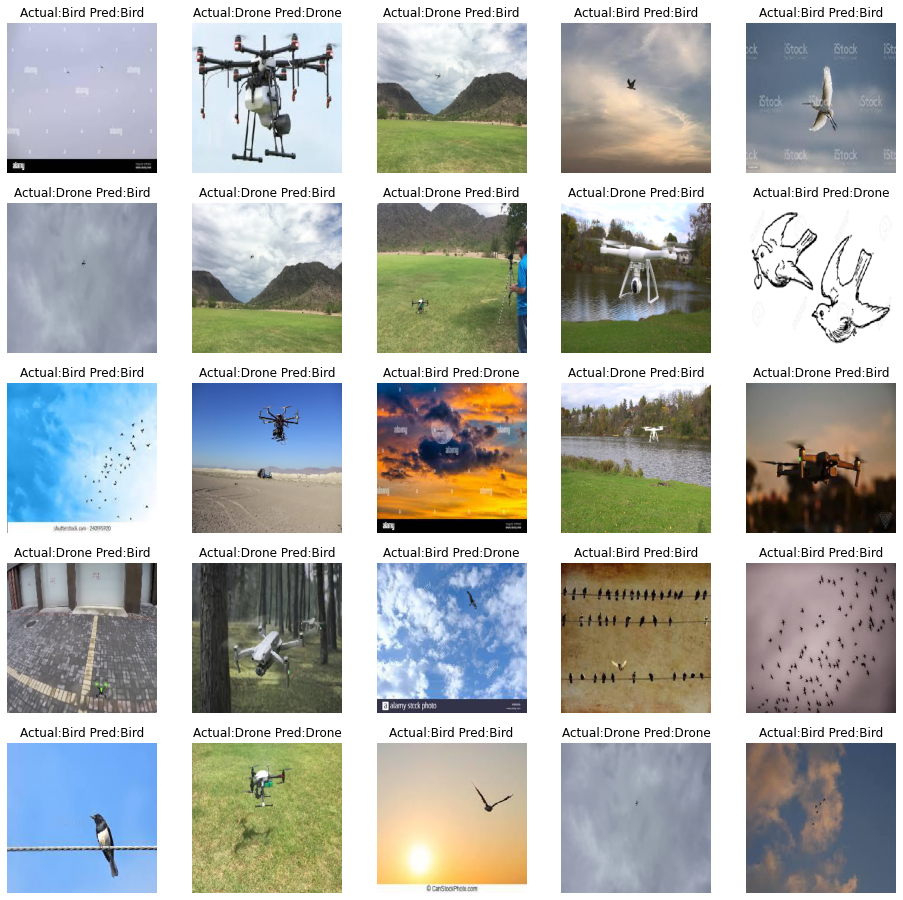

In [ ]:
w = 10
h = 10

label_dict={0:'Bird',1:'Drone'}

x= test_data.next()
image = x[0]      # img=x[0], label=x[1]
labels=x[1]
fig = plt.figure(figsize=(16, 16))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = image[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'Actual:{label_dict[int(labels[i])]} Pred:{label_dict[int(y_test_pred_aug_index[i])]}')
    plt.axis('off')
plt.show()

# Combine AUC

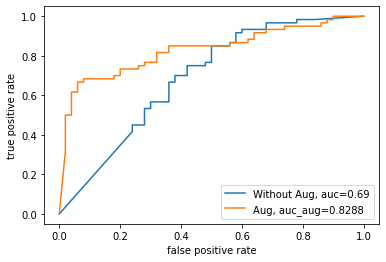

In [ ]:
#plot combine  roc curve

plt.plot(fpr,tpr,label="Without Aug, auc="+str(round(auc,4)))
plt.plot(fpr_a,tpr_a,label="Aug, auc_aug="+str(round(auc_aug,4)))
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.legend(loc=4)
plt.show()
